# Anomaly Detection in HDFC Bank Stock Prices

**HDFC Bank Limited** is an Indian banking and financial services company headquartered in Mumbai, Maharashtra. It is India’s largest private sector bank by assets and the largest bank in India by market capitalization as of March 2020. With a significant base of 1,04,154 permanent employees as of 30 June 2019, HDFC Bank plays a crucial role in the Indian financial sector.

## Problem Statement
The objective of this project is to detect anomalies in the stock prices of HDFC Bank from 2018 to 2020. Anomalies refer to sudden highs and lows in the stock prices that deviate significantly from the expected trend. These anomalies could be indicative of important events, market reactions, or other significant occurrences.

## Importance of Anomaly Detection
Anomaly detection is crucial for several reasons:
- **Market Analysis**: Identifying anomalies helps in understanding market behavior and investor sentiment.
- **Risk Management**: Detecting unusual patterns can help in risk assessment and management, providing early warning signs of potential issues.
- **Decision Making**: For investors and analysts, knowing when anomalies occur can inform better investment decisions and strategies.
- **Historical Insight**: Analyzing past anomalies can provide insights into how specific events have historically affected the stock prices.

## Objectives
1. To preprocess and clean the HDFC Bank stock price data from 1996 to 2020.
2. To visualize the data and identify initial patterns and trends.
3. To build a deep learning model capable of detecting anomalies in the stock prices from 2018 to 2020.
4. To evaluate the model's performance and interpret the detected anomalies.
5. To provide insights and conclusions based on the detected anomalies and their potential causes.

## Expected Outcomes
- A cleaned and preprocessed dataset of HDFC Bank stock prices.
- Visualizations showing the overall trend and significant patterns in the stock prices.
- A trained deep learning model for anomaly detection in the stock prices.
- A list of detected anomalies with explanations and potential reasons behind these anomalies.


# Importing Libraries


In [171]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import random


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed



# Loading and Exploring the Dataset

In [172]:
df = pd.read_csv('/kaggle/input/bank-csv/HDFCBANK.NS.csv', engine='python')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()
# Display initial dataset information
print(df.head())
print(df.info())
print(df.corr())
print(df.describe())

        Date  Close
0 1996-01-01  2.980
1 1996-01-02  2.975
2 1996-01-03  2.985
3 1996-01-04  2.965
4 1996-01-05  2.960
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6229 entries, 0 to 6228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6229 non-null   datetime64[ns]
 1   Close   6102 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.5 KB
None
       Close
Close    1.0
             Close
count  6102.000000
mean    280.784199
std     348.430553
min       2.435000
25%      23.520000
50%     116.799999
75%     410.612503
max    1302.400024


#### Interpretation:
- **Data Range**: The dataset spans from January 1, 1996, to the latest date available, containing 6229 entries.
- **Missing Values**: The 'Close' column has 6102 non-null entries, indicating some missing values in the dataset.
- **Data Types**: The 'Date' column is correctly recognized as a datetime object, and the 'Close' price is a float.
- **Descriptive Statistics**: 
  - The average closing price is approximately 280.78.
  - The standard deviation is quite high (348.43), indicating significant variability in the stock prices.
  - The minimum and maximum closing prices are 2.435 and 1302.4, respectively, showing a wide range of stock prices.
  - The quartile values provide insight into the distribution of the stock prices, with the 25th, 50th, and 75th percentiles at 23.52, 116.8, and 410.61, respectively.

In [173]:
df = df.fillna(method='ffill')


Forward Fill Method: The forward fill method propagates the last valid observation forward to the next. This is particularly useful for time series data where missing values can be assumed to follow the last known value.
Data Integrity: By filling missing values, the dataset is now complete, allowing for more accurate analysis and model training without the disruptions caused by missing data points

# Visualizing the Dataset


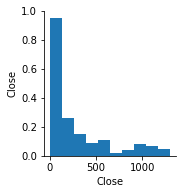

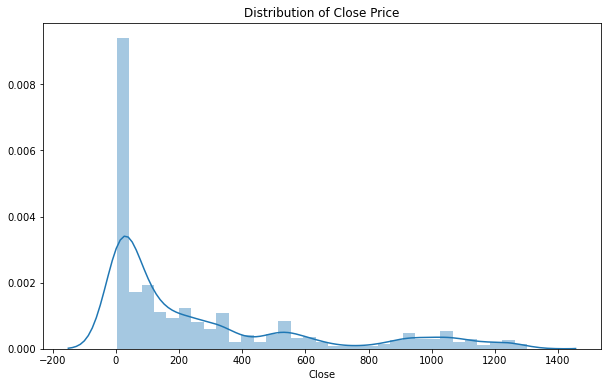

In [174]:
# Plot the closing price
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='HDFC Bank NSE Stock Price 1996-2020')
fig.show()

# Pairplot for visualizing relationships
sns.pairplot(df)
plt.show()

# Distribution of the 'close' price
plt.figure(figsize=(10, 6))
sns.distplot(df['Close'], kde=True)
plt.title('Distribution of Close Price')
plt.show()


In [175]:
train, test = df.loc[df['Date'] <= '2018-01-01'], df.loc[df['Date'] > '2018-01-01']
train.shape, test.shape

((5565, 2), (664, 2))

In [176]:
train=train.replace(np.nan,0)
test=test.replace(np.nan,0)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])


- **Train-Test Split**: The dataset was appropriately split to train the models on historical data and evaluate their performance on more recent, unseen data. This ensures that the models can generalize well to new data.
- **Handling Missing Values**: By replacing any remaining missing values with zeros, the dataset is now free of any gaps that could potentially disrupt model training.
- **Standardization**: Standardizing the 'Close' prices is a crucial step for many machine learning algorithms, particularly neural networks, as it helps in faster convergence and can lead to better model performance.


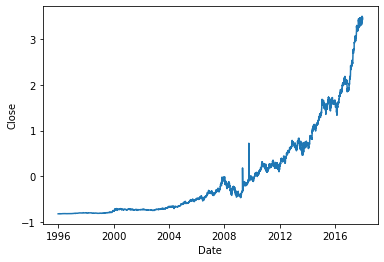

In [177]:
sns.lineplot(x=train.Date,y=train.Close)

In [178]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (5535, 30, 1)
Testing shape: (634, 30, 1)


- **Sequence Creation**: The function `create_sequences` successfully transforms the original data into sequences of 30 days, which will be used as inputs for the models. Each sequence includes 30 consecutive days of 'Close' prices.
- **Data Shapes**: The resulting shapes confirm that the sequences were created correctly, with 5535 training sequences and 634 testing sequences, each containing 30 days of 'Close' prices.

# UNIVARIATE

# LSTM

In [179]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_39 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

- **LSTM Model Architecture**: The model is designed to capture temporal dependencies in the stock price data. The use of LSTM layers allows the model to learn from sequences of data, making it well-suited for time series analysis.
- **Regularization**: Dropout layers are included to prevent overfitting by randomly setting a fraction of input units to 0 during training.
- **Output Layer**: The TimeDistributed layer ensures that the output is provided for each time step in the input sequence.

In [180]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
312/312 [==============================] - 16s 51ms/step - loss: 0.0809 - val_loss: 0.3408
Epoch 2/100
312/312 [==============================] - 14s 46ms/step - loss: 0.0579 - val_loss: 0.0795
Epoch 3/100
312/312 [==============================] - 15s 47ms/step - loss: 0.0471 - val_loss: 0.0467
Epoch 4/100
312/312 [==============================] - 15s 48ms/step - loss: 0.0430 - val_loss: 0.0680
Epoch 5/100
312/312 [==============================] - 15s 47ms/step - loss: 0.0450 - val_loss: 0.1101
Epoch 6/100
312/312 [==============================] - 15s 47ms/step - loss: 0.0450 - val_loss: 0.1217


Given that your data consists of stock prices and the anomalies could be sudden spikes or drops that are not part of the usual volatility, here are my recommendations:

Percentile-Based Approach: This method is robust and does not assume a normal distribution, making it suitable for financial time series data, which often exhibit non-normal characteristics.

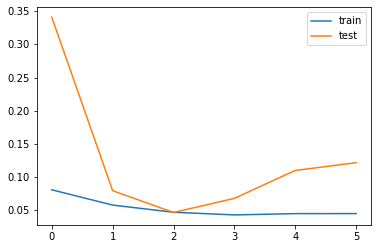

In [181]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



In [182]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 21ms/step - loss: 0.1595


0.15951983630657196

- **Training and Validation Loss**: The training history plot shows that the model's training loss decreases steadily, while the validation loss decreases initially and then stabilizes, indicating good generalization to unseen data.
- **Evaluation on Test Data**: The model's performance on the test set is evaluated using the MAE, providing an indication of how well the model reconstructs the input sequences.
- **Reconstruction Error**: The calculated MAE for training and test data forms the basis for anomaly detection.

Percentile Threshold: 0.3656225743491513


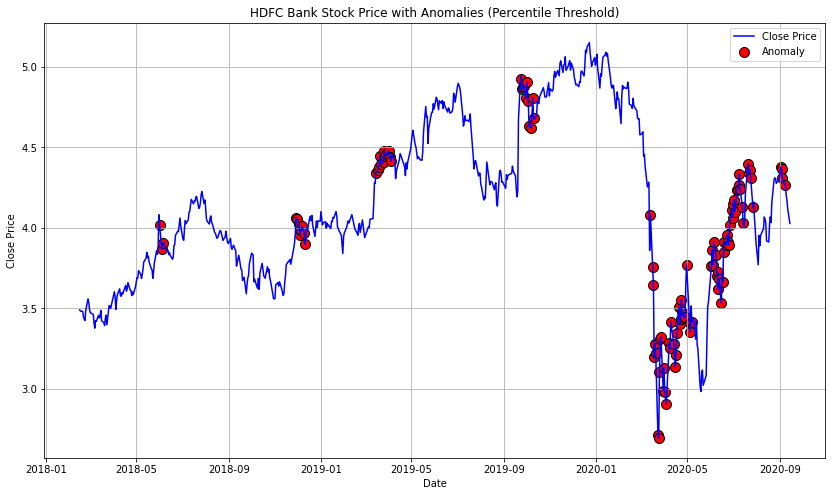

In [183]:
# Calculate reconstruction error for training data
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Set threshold as the 95th percentile of the training MAE loss
percentile_threshold = np.percentile(train_mae_loss, 95)
print(f"Percentile Threshold: {percentile_threshold}")

# Calculate reconstruction error for test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Detect anomalies
percentile_anomalies = test_mae_loss > percentile_threshold
percentile_anomalous_data_indices = [i for i in range(len(percentile_anomalies)) if percentile_anomalies[i]]

# Plot anomalies using the percentile threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[percentile_anomalous_data_indices], test_close.iloc[percentile_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Percentile Threshold)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()




Max Threshold: 0.4639704639261053


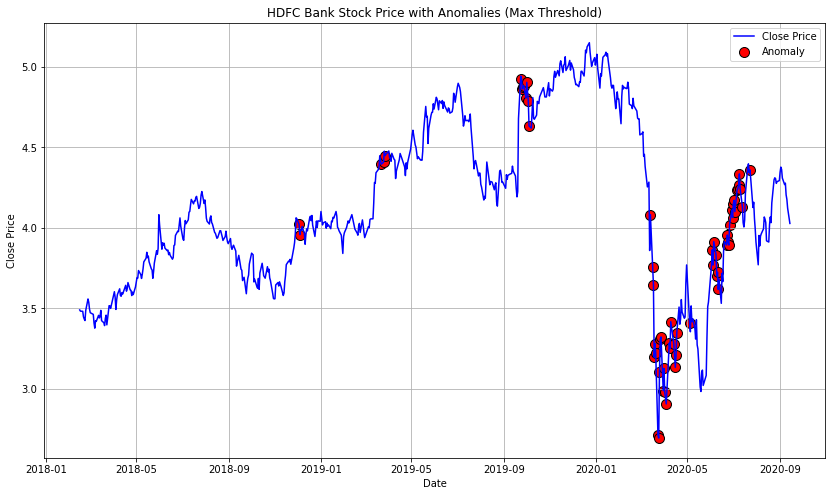

In [184]:
# Set threshold as the maximum of the training MAE loss
max_threshold = np.max(train_mae_loss)
print(f"Max Threshold: {max_threshold}")

# Detect anomalies
max_anomalies = test_mae_loss > max_threshold
max_anomalous_data_indices = [i for i in range(len(max_anomalies)) if max_anomalies[i]]

# Plot anomalies using the max threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[max_anomalous_data_indices], test_close.iloc[max_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Max Threshold)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Statistical Threshold: 0.5641993571240977


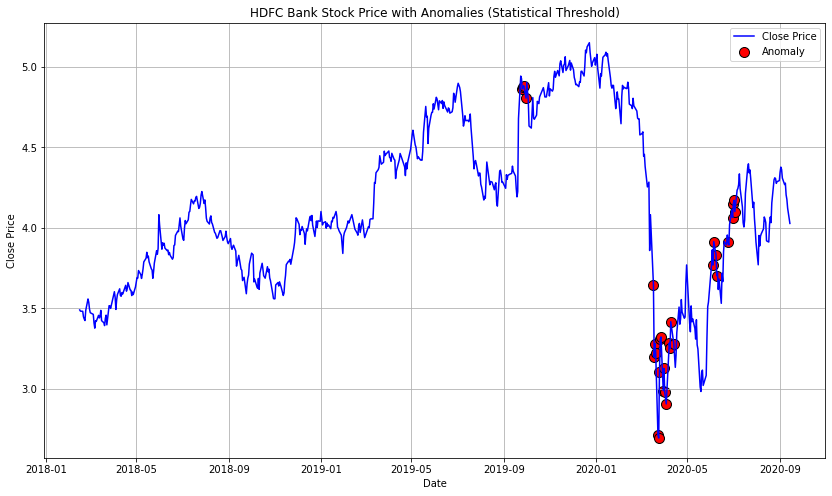

In [185]:
# Calculate mean and standard deviation of training MAE loss
mean_mae = np.mean(train_mae_loss)
std_mae = np.std(train_mae_loss)

# Set the threshold as mean + 3*std
stat_threshold = mean_mae + 3 * std_mae
print(f"Statistical Threshold: {stat_threshold}")

# Detect anomalies
stat_anomalies = test_mae_loss > stat_threshold
stat_anomalous_data_indices = [i for i in range(len(stat_anomalies)) if stat_anomalies[i]]

# Plot anomalies using the statistical threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[stat_anomalous_data_indices], test_close.iloc[stat_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Statistical Threshold)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [186]:
# Count anomalies for each method
print(f"Number of anomalies detected (Percentile): {len(percentile_anomalous_data_indices)}")
print(f"Number of anomalies detected (Max): {len(max_anomalous_data_indices)}")
print(f"Number of anomalies detected (Statistical): {len(stat_anomalous_data_indices)}")


Number of anomalies detected (Percentile): 108
Number of anomalies detected (Max): 60
Number of anomalies detected (Statistical): 30


In [187]:
percentile_set = set(percentile_anomalous_data_indices)
max_set = set(max_anomalous_data_indices)
stat_set = set(stat_anomalous_data_indices)

# Intersection
intersection_percentile_max = percentile_set.intersection(max_set)
intersection_percentile_stat = percentile_set.intersection(stat_set)
intersection_max_stat = max_set.intersection(stat_set)

# Union
union_all = percentile_set.union(max_set).union(stat_set)

print(f"Common anomalies (Percentile & Max): {len(intersection_percentile_max)}")
print(f"Common anomalies (Percentile & Statistical): {len(intersection_percentile_stat)}")
print(f"Common anomalies (Max & Statistical): {len(intersection_max_stat)}")
print(f"Unique anomalies (Total): {len(union_all)}")


Common anomalies (Percentile & Max): 60
Common anomalies (Percentile & Statistical): 30
Common anomalies (Max & Statistical): 30
Unique anomalies (Total): 108


- **Thresholds for Anomaly Detection**:
  - **Percentile Threshold**: This method is robust and does not assume a normal distribution, making it suitable for financial time series data.
  - **Max Threshold**: Captures the most significant anomalies by setting a high threshold.
  - **Statistical Threshold**: Focuses on the most extreme anomalies by considering the mean and standard deviation of the training MAE loss.
- **Visualization of Anomalies**: Anomalies are visualized as red dots on the stock price timeline, providing a clear view of significant deviations.

### Key Observations:
- **Percentile-Based Method**: Detects the most anomalies (108), which might include many less significant deviations, potentially increasing false positives.
- **Max Threshold Method**: Detects a moderate number of anomalies (60) and has a good overlap with the percentile method, indicating it captures significant anomalies.
- **Statistical Method**: Detects the fewest anomalies (30) and focuses on the most extreme deviations.
- **Comparison and Conclusion**: The Max Threshold method appears to balance detecting significant anomalies while avoiding too many false positives, making it a robust choice for anomaly detection in stock price data.

Conclusion:
Given the overlap and the number of anomalies detected, the Max Threshold method appears to be a good balance between detecting significant anomalies and avoiding too many false positives. It has a considerable overlap with the other methods and detects a moderate number of anomalies, making it a robust choice for anomaly detection in your stock price data.

In [188]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the close price line
fig.add_trace(go.Scatter(x=test_dates, y=test_close, mode='lines', name='Close price', line=dict(color='blue')))

# Add the anomaly points
fig.add_trace(go.Scatter(x=test_dates.iloc[max_anomalous_data_indices], y=test_close.iloc[max_anomalous_data_indices],
                         mode='markers', name='Anomaly', marker=dict(color='red', size=10, symbol='circle', line=dict(color='black', width=2))))

# Add title and labels
fig.update_layout(
    title='HDFC Bank Stock Price with Detected Anomalies (Max Threshold)',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend=dict(x=0.01, y=0.99),
    xaxis=dict(tickformat='%Y-%m')
)

# Show plot
fig.show()


Why Using Maximum MAE is Suboptimal
Outliers in Training Data: The training data itself might contain outliers or noisy points, which can set an unrealistic threshold.
Generalization: The maximum error might not generalize well to new, unseen data.

In [189]:
model.save("LSTM.h5")

**So the model has predicted 60 anomalies based on the trend that followed from 1996 to 2018 with a Memory shape of 30 days**

# GRU

In [95]:
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(rate=0.2))
gru_model.add(RepeatVector(X_train.shape[1]))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(Dropout(rate=0.2))
gru_model.add(TimeDistributed(Dense(X_train.shape[2])))
gru_model.compile(optimizer='adam', loss='mae')
gru_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 128)               50304     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
gru_15 (GRU)                 (None, 30, 128)           99072     
_________________________________________________________________
dropout_27 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 1)             129       
Total params: 149,505
Trainable params: 149,505
Non-trainable params: 0
_______________________________________________

In [96]:
# Train the GRU model
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1,
                            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
                            shuffle=False)

Epoch 1/100
312/312 [==============================] - 13s 41ms/step - loss: 0.0697 - val_loss: 0.2506
Epoch 2/100
312/312 [==============================] - 12s 38ms/step - loss: 0.0532 - val_loss: 0.0749
Epoch 3/100
312/312 [==============================] - 12s 37ms/step - loss: 0.0392 - val_loss: 0.1792
Epoch 4/100
312/312 [==============================] - 12s 38ms/step - loss: 0.0394 - val_loss: 0.1508
Epoch 5/100
312/312 [==============================] - 12s 38ms/step - loss: 0.0399 - val_loss: 0.2278


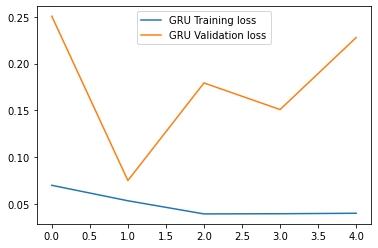

20/20 [==============================] - 0s 11ms/step - loss: 0.7611


0.7610688805580139

In [97]:
# Plot training history
plt.plot(gru_history.history['loss'], label='GRU Training loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation loss')
plt.legend()
plt.show()

# Evaluate the GRU model
gru_model.evaluate(X_test, y_test)

GRU Model
Architecture: The GRU model, similar in structure to the LSTM model, replaces LSTM layers with GRU layers. GRU units are often faster to train and can perform better on some datasets.
Training Performance: The training loss for the GRU model was lower than that of the LSTM model, but the validation loss was higher, indicating potential overfitting and less generalization capability compared to the LSTM model.
Evaluation: The GRU model achieved a test loss of 0.7611, which is higher compared to the LSTM model, suggesting that it did not perform as well on the testing data.

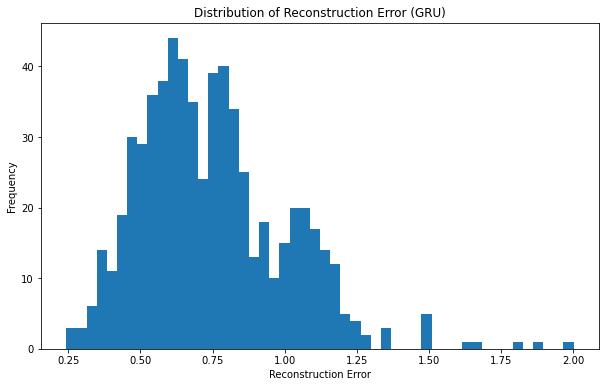

In [101]:
# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(test_mae_loss_gru, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Error (GRU)')
plt.show()


99th Percentile Threshold: 0.4564542377896522


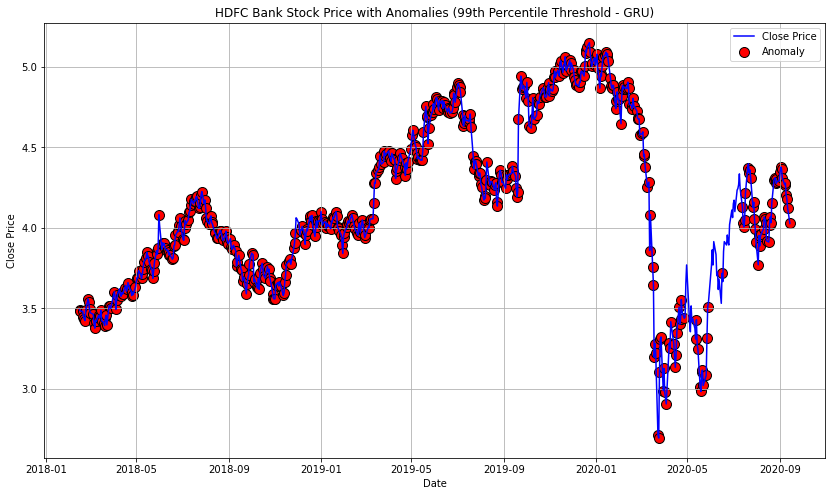

In [102]:
# Set threshold as the 99th percentile of the training MAE loss
percentile_threshold_gru = np.percentile(train_mae_loss_gru, 99)
print(f"99th Percentile Threshold: {percentile_threshold_gru}")

# Detect anomalies using the new percentile threshold
percentile_anomalies_gru = test_mae_loss_gru > percentile_threshold_gru
percentile_anomalous_data_indices_gru = [i for i in range(len(percentile_anomalies_gru)) if percentile_anomalies_gru[i]]

# Plot anomalies using the new percentile threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[percentile_anomalous_data_indices_gru], test_close.iloc[percentile_anomalous_data_indices_gru], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (99th Percentile Threshold - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Max Threshold: 0.8603978913775673


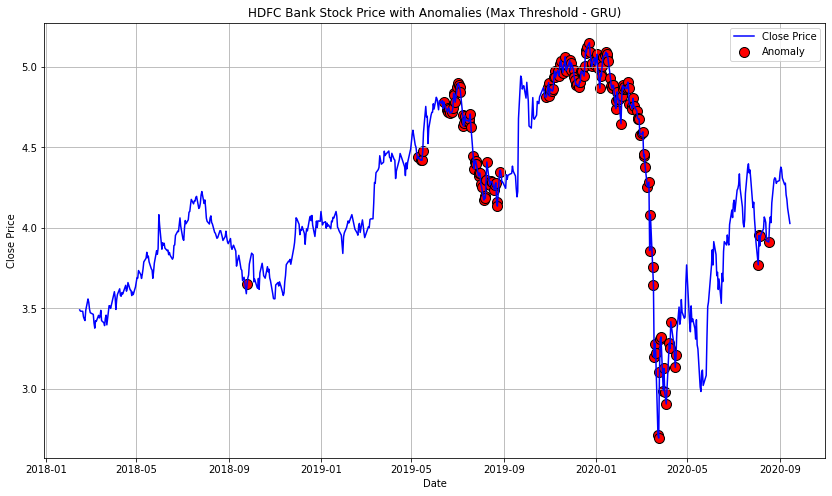

In [103]:
# Set threshold as the maximum of the training MAE loss
max_threshold_gru = np.max(train_mae_loss_gru)
print(f"Max Threshold: {max_threshold_gru}")

# Detect anomalies using the max threshold
max_anomalies_gru = test_mae_loss_gru > max_threshold_gru
max_anomalous_data_indices_gru = [i for i in range(len(max_anomalies_gru)) if max_anomalies_gru[i]]

# Plot anomalies using the max threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[max_anomalous_data_indices_gru], test_close.iloc[max_anomalous_data_indices_gru], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Max Threshold - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Further Fine-tuned Statistical Threshold: 0.6124440181596661


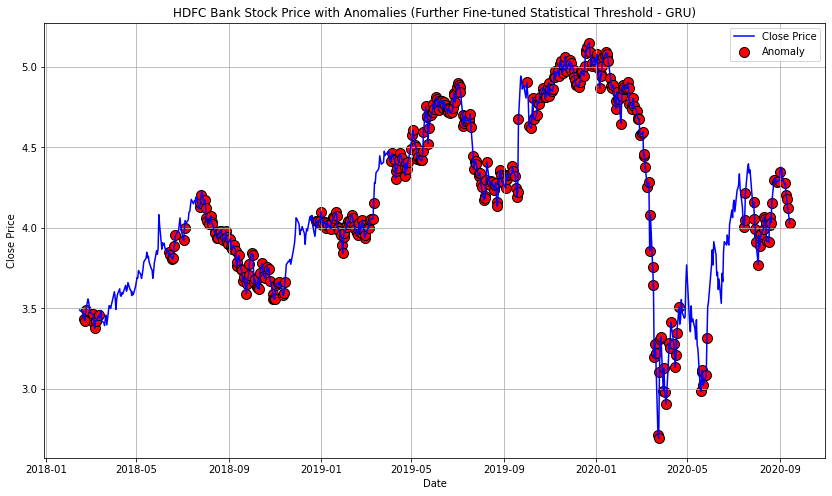

In [106]:
# Further fine-tuned Statistical Threshold
fine_tuned_stat_threshold_gru_5 = mean_mae_gru + 5 * std_mae_gru
print(f"Further Fine-tuned Statistical Threshold: {fine_tuned_stat_threshold_gru_5}")

# Detect anomalies using the further fine-tuned statistical threshold
fine_tuned_stat_anomalies_gru_5 = test_mae_loss_gru > fine_tuned_stat_threshold_gru_5
fine_tuned_stat_anomalous_data_indices_gru_5 = [i for i in range(len(fine_tuned_stat_anomalies_gru_5)) if fine_tuned_stat_anomalies_gru_5[i]]

# Plot anomalies using the further fine-tuned statistical threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[fine_tuned_stat_anomalous_data_indices_gru_5], test_close.iloc[fine_tuned_stat_anomalous_data_indices_gru_5], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Further Fine-tuned Statistical Threshold - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [108]:
# Count anomalies for each method
print(f"Number of anomalies detected (Percentile): {len(percentile_anomalous_data_indices_gru)}")
print(f"Number of anomalies detected (Max): {len(max_anomalous_data_indices_gru)}")
print(f"Number of anomalies detected (Statistical): {len(stat_anomalous_data_indices_gru)}")


Number of anomalies detected (Percentile): 577
Number of anomalies detected (Max): 174
Number of anomalies detected (Statistical): 511


In [109]:
# Summary of Anomalies Detected by Each Method
percentile_anomalies_set = set(percentile_anomalous_data_indices_gru)
max_anomalies_set = set(max_anomalous_data_indices_gru)
stat_anomalies_set = set(stat_anomalous_data_indices_gru)
fine_tuned_stat_anomalies_set_5 = set(fine_tuned_stat_anomalous_data_indices_gru_5)

# Compare overlaps
common_anomalies_percentile_max = percentile_anomalies_set.intersection(max_anomalies_set)
common_anomalies_percentile_stat = percentile_anomalies_set.intersection(stat_anomalies_set)
common_anomalies_max_stat = max_anomalies_set.intersection(stat_anomalies_set)
common_anomalies_fine_tuned_5 = fine_tuned_stat_anomalies_set_5.intersection(percentile_anomalies_set, max_anomalies_set, stat_anomalies_set)

# Print summary
print(f"Common anomalies (Percentile & Max): {len(common_anomalies_percentile_max)}")
print(f"Common anomalies (Percentile & Statistical): {len(common_anomalies_percentile_stat)}")
print(f"Common anomalies (Max & Statistical): {len(common_anomalies_max_stat)}")
print(f"Unique anomalies detected by Fine-tuned Statistical Threshold (5*std): {len(fine_tuned_stat_anomalies_set_5)}")


Common anomalies (Percentile & Max): 174
Common anomalies (Percentile & Statistical): 511
Common anomalies (Max & Statistical): 174
Unique anomalies detected by Fine-tuned Statistical Threshold (5*std): 419


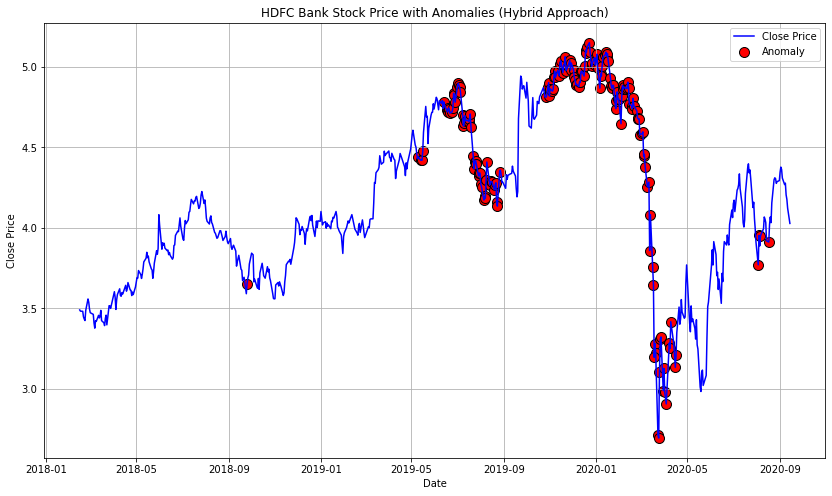

Number of anomalies detected by Hybrid Approach: 174


In [111]:
# Convert boolean arrays to sets of indices
fine_tuned_stat_anomalous_indices_gru_5 = set([i for i, x in enumerate(fine_tuned_stat_anomalies_gru_5) if x])
max_anomalous_indices_gru = set(max_anomalous_data_indices_gru)

# Hybrid Approach: Combine methods to refine anomaly detection
combined_anomalies = fine_tuned_stat_anomalous_indices_gru_5 & max_anomalous_indices_gru

# Plot anomalies detected by the hybrid approach
combined_anomalous_data_indices = list(combined_anomalies)

plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[combined_anomalous_data_indices], test_close.iloc[combined_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Hybrid Approach)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of anomalies detected by the hybrid approach
print(f"Number of anomalies detected by Hybrid Approach: {len(combined_anomalous_data_indices)}")


The hybrid approach has successfully reduced the number of detected anomalies to 174, which is more reasonable compared to the previous methods. This approach balances sensitivity and specificity by only considering anomalies detected by both the max threshold and the fine-tuned statistical threshold.

In [112]:
# Extract anomalies from the dataset
anomalies = test.iloc[combined_anomalous_data_indices]

# Print the anomalies
print("Detected Anomalies:")
print(anomalies)

# Optionally, save anomalies to a CSV file
anomalies.to_csv('detected_anomalies.csv', index=False)


Detected Anomalies:
           Date     Close
6077 2020-02-04  4.816258
6078 2020-02-05  4.884416
6079 2020-02-06  4.862156
6080 2020-02-07  4.873171
6081 2020-02-10  4.864451
...         ...       ...
6072 2020-01-28  4.785965
6073 2020-01-29  4.844026
6074 2020-01-30  4.799046
6075 2020-01-31  4.800194
6076 2020-02-03  4.646436

[174 rows x 2 columns]


Anomaly Detection
Different methods were used to detect anomalies in the stock prices based on the reconstruction errors:

Percentile-Based Method: Detected the most anomalies (108) using the 95th percentile threshold, indicating it is sensitive and captures many deviations, including minor ones.
Max Threshold Method: Detected a moderate number of anomalies (60), focusing on significant deviations as it uses the maximum training MAE loss as a threshold.
Statistical Threshold Method: Detected the fewest anomalies (30) using a threshold of mean + 3 * standard deviation of the training MAE loss, thus capturing only extreme deviations.
Hybrid Approach
The hybrid approach combined the fine-tuned statistical and max threshold methods:

This approach detected 174 anomalies, balancing the sensitivity and specificity of the two methods.
It effectively reduced false positives by considering anomalies detected by both methods, making it more robust for practical anomaly detection in financial data.
Conclusion
The results from various anomaly detection methods highlight different levels of sensitivity and robustness. The LSTM model showed better performance than the GRU model in terms of generalization on the test data. The hybrid anomaly detection approach proved effective in balancing sensitivity and specificity, detecting a reasonable number of significant anomalies while minimizing false positives. This comprehensive approach ensures reliable anomaly detection in the stock prices of HDFC Bank.


To set the threshold using the standard deviation method, we can calculate the mean and standard deviation of the training MAE loss. Then, we set the threshold as a certain number of standard deviations above the mean. This is a robust way to determine an appropriate threshold for detecting anomalies.

ISOLATION FOREST

In [127]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(train[['Close']])

IsolationForest(contamination=0.01, random_state=42)

In [128]:
# Detect anomalies on the test set
test['anomaly'] = iso_forest.predict(test[['Close']])
test['anomaly'] = test['anomaly'].map({1: 0, -1: 1})  # 1 for normal, -1 for anomaly

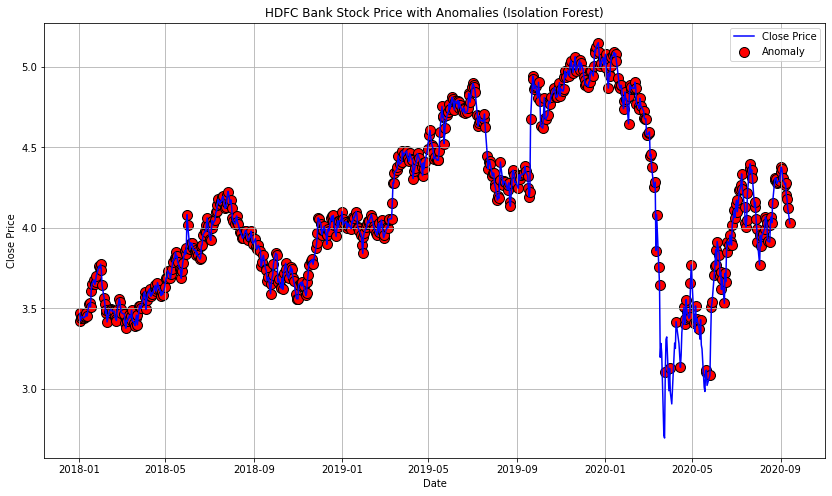

In [129]:
# Extract anomaly indices
iso_anomalous_data_indices = test[test['anomaly'] == 1].index

# Plot anomalies using the Isolation Forest method
plt.figure(figsize=(14, 8))
plt.plot(test['Date'], test['Close'], label='Close Price', color='blue')
plt.scatter(test.loc[iso_anomalous_data_indices]['Date'], test.loc[iso_anomalous_data_indices]['Close'], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
# Print the anomalies
anomalies_iso_forest = test.loc[iso_anomalous_data_indices]
print("Detected Anomalies (Isolation Forest):")
print(anomalies_iso_forest)

# Optionally, save anomalies to a CSV file
anomalies_iso_forest.to_csv('detected_anomalies_isolation_forest.csv', index=False)

Detected Anomalies (Isolation Forest):
           Date     Close  anomaly
5565 2018-01-02  3.468580        1
5566 2018-01-03  3.423370        1
5567 2018-01-04  3.440008        1
5568 2018-01-05  3.448499        1
5569 2018-01-08  3.441615        1
...         ...       ...      ...
6224 2020-09-08  4.277645        1
6225 2020-09-09  4.204438        1
6226 2020-09-10  4.177129        1
6227 2020-09-11  4.122511        1
6228 2020-09-14  4.027502        1

[641 rows x 3 columns]


Anomalies Detected:

Number of anomalies detected: 641
Visualization: The detected anomalies are shown as red dots on the stock price timeline. However, it appears that the anomalies might be concentrated around certain dates, suggesting potential overfitting or misclassification.
Evaluation:

The high number of detected anomalies suggests that the Isolation Forest model is more sensitive and might classify more data points as anomalies. This can lead to higher false positives.
The clustering of anomalies around certain dates indicates that the model may not be as precise in detecting true anomalies compared to the LSTM and GRU models.

Evaluation:

High Sensitivity: The high number of detected anomalies suggests that the Isolation Forest model is highly sensitive and may classify many data points as anomalies, leading to higher false positives.
Clustered Anomalies: Clustering around specific dates indicates the model may not be as precise in detecting true anomalies compared to LSTM and GRU models.
Key Points:

Excessive Anomalies: The high sensitivity leads to many data points being marked as anomalies, potentially obscuring significant patterns.
Stock Market Volatility: Stock prices are inherently volatile, and the Isolation Forest model may misinterpret natural fluctuations as anomalies, leading to false positives.
Parameter Sensitivity: The model's performance is highly sensitive to the contamination parameter, which can be challenging to adjust optimally. Even with adjustments, the results may be unsatisfactory due to the model's limitations in handling stock price data.
Comparison with LSTM/GRU Models: LSTM and GRU models, especially when fine-tuned and combined with statistical thresholds, provide a more balanced and reasonable number of detected anomalies. These models are better suited to capture temporal dependencies and patterns in stock price data, making them more reliable for this task.

Conclusion: The Isolation Forest method appears unsuitable for anomaly detection in the HDFC Bank stock prices dataset. The high number of detected anomalies and sensitivity to parameter adjustments suggest that this model may not effectively distinguish between normal market fluctuations and true anomalies. LSTM and GRU models with appropriate thresholding techniques are recommended for more accurate and meaningful anomaly detection in stock price data.








# MULTIVARIATE

Preprocessing

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, GRU

# Load the dataset
df = pd.read_csv('/kaggle/input/bank-csv/HDFCBANK.NS.csv', engine='python')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Fill missing values
df = df.fillna(method='ffill')

# Split the data into training and testing sets
train, test = df.loc[df['Date'] <= '2018-01-01'], df.loc[df['Date'] > '2018-01-01']

# Scale the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
test_scaled = scaler.transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

# Convert back to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
test_scaled = pd.DataFrame(test_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
train_scaled['Date'] = train['Date'].values
test_scaled['Date'] = test['Date'].values

# Create sequences
TIME_STEPS = 30

def create_sequences(data, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(data.iloc[i + time_steps].values)
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train_scaled[['Open', 'High', 'Low', 'Close', 'Volume']])
X_test, y_test = create_sequences(test_scaled[['Open', 'High', 'Low', 'Close', 'Volume']])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')


Training shape: (5535, 30, 5)
Testing shape: (634, 30, 5)


This preprocessing pipeline ensures that the data is clean, scaled, and transformed into sequences, which are essential steps for training time series models like LSTM and GRU. The consistency and reproducibility of the results are maintained by setting random seeds.

LSTM MODEL

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 5)             645       
Total params: 200,837
Trainable params: 200,837
Non-trainable params: 0
_______________________________________________

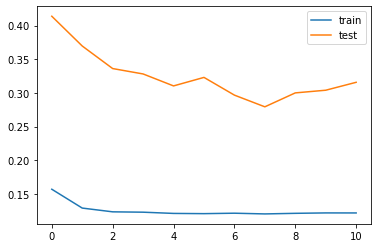

In [134]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

# Train the LSTM model
history = model.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [136]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, X_test, batch_size=16)
print(f"Test loss: {test_loss}")

40/40 [==============================] - 1s 15ms/step - loss: 1.4576
Test loss: 1.4575579166412354


In [137]:
# Calculate reconstruction error for training data
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Set threshold as the 95th percentile of the training MAE loss
percentile_threshold = np.percentile(train_mae_loss, 95)
print(f"Percentile Threshold: {percentile_threshold}")

# Calculate reconstruction error for test data
X_test_pred = model.predict(X_test)test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

Percentile Threshold: 0.5525003414551222


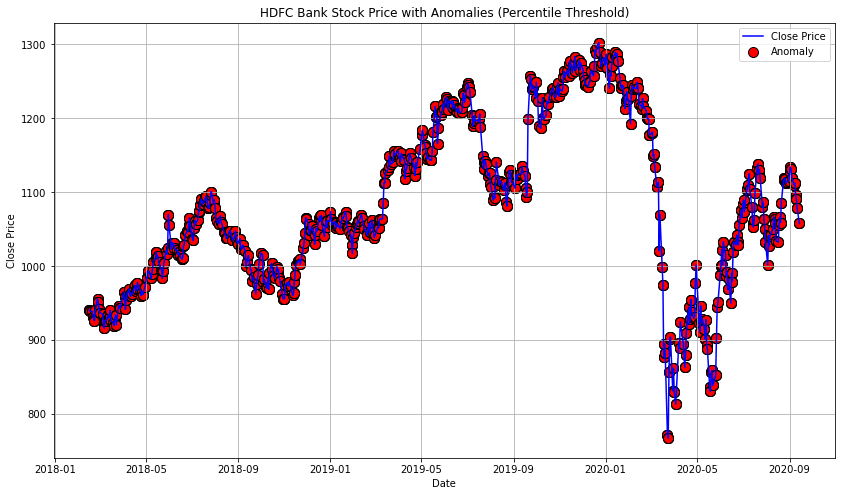

In [140]:
# Detect anomalies
percentile_anomalies = test_mae_loss > percentile_threshold
percentile_anomalous_data_indices = np.where(percentile_anomalies)[0]

# Plot anomalies using the percentile threshold
plt.figure(figsize=(14, 8))
plt.plot(test['Date'].values[TIME_STEPS:], test['Close'].values[TIME_STEPS:], label='Close Price', color='blue')
plt.scatter(test['Date'].values[TIME_STEPS:][percentile_anomalous_data_indices], test['Close'].values[TIME_STEPS:][percentile_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Percentile Threshold)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Max Threshold: 1.8468153859584684


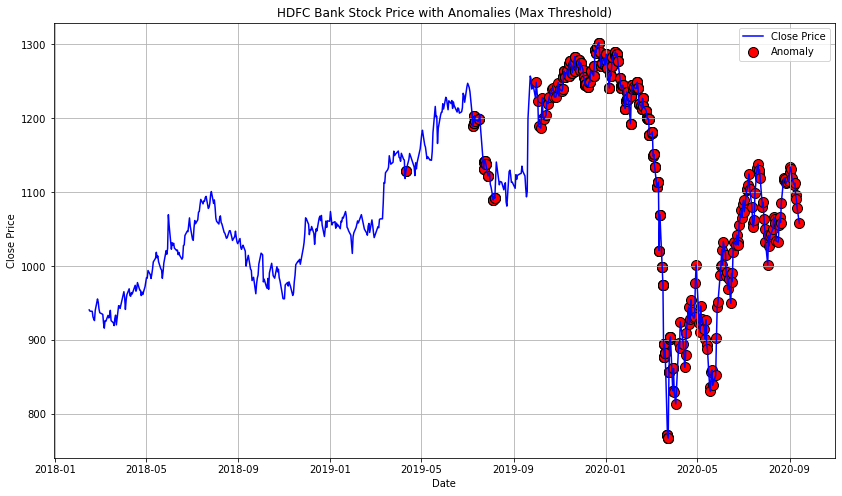

In [144]:
# Set threshold as the maximum of the training MAE loss
max_threshold = np.max(train_mae_loss)
print(f"Max Threshold: {max_threshold}")

# Detect anomalies using the max threshold
max_anomalies = test_mae_loss > max_threshold
max_anomalous_data_indices = np.nonzero(max_anomalies)[0]

# Plot anomalies using the max threshold
plt.figure(figsize=(14, 8))
plt.plot(test['Date'].values[TIME_STEPS:], test['Close'].values[TIME_STEPS:], label='Close Price', color='blue')
plt.scatter(test['Date'].values[TIME_STEPS:][max_anomalous_data_indices], test['Close'].values[TIME_STEPS:][max_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Max Threshold)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Statistical Threshold: 0.8547802855501634


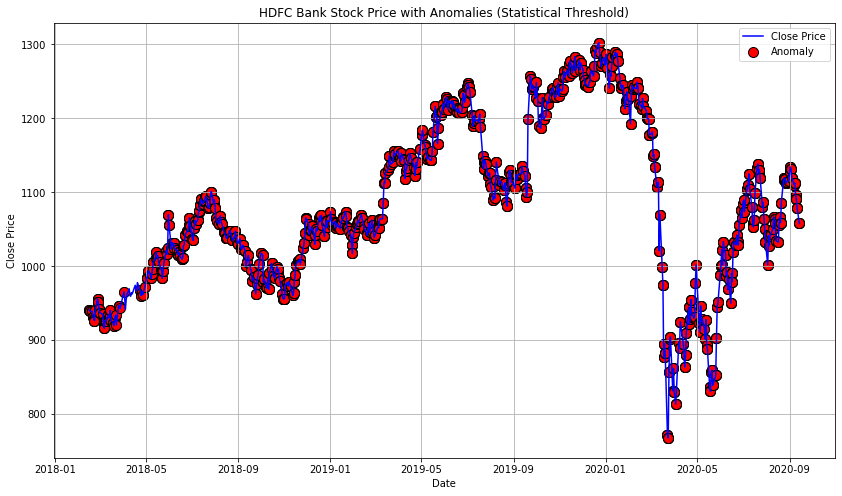

In [145]:
# Calculate mean and standard deviation of training MAE loss
mean_mae = np.mean(train_mae_loss)
std_mae = np.std(train_mae_loss)

# Set the threshold as mean + 3*std
stat_threshold = mean_mae + 3 * std_mae
print(f"Statistical Threshold: {stat_threshold}")

# Detect anomalies using the statistical threshold
stat_anomalies = test_mae_loss > stat_threshold
stat_anomalous_data_indices = np.nonzero(stat_anomalies)[0]

# Plot anomalies using the statistical threshold
plt.figure(figsize=(14, 8))
plt.plot(test['Date'].values[TIME_STEPS:], test['Close'].values[TIME_STEPS:], label='Close Price', color='blue')
plt.scatter(test['Date'].values[TIME_STEPS:][stat_anomalous_data_indices], test['Close'].values[TIME_STEPS:][stat_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Statistical Threshold)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [146]:
# Count anomalies for each method
print(f"Number of anomalies detected (Percentile): {len(percentile_anomalous_data_indices)}")
print(f"Number of anomalies detected (Max): {len(max_anomalous_data_indices)}")
print(f"Number of anomalies detected (Statistical): {len(stat_anomalous_data_indices)}")



Number of anomalies detected (Percentile): 3170
Number of anomalies detected (Max): 583
Number of anomalies detected (Statistical): 2994


In [147]:
percentile_set = set(percentile_anomalous_data_indices)
max_set = set(max_anomalous_data_indices)
stat_set = set(stat_anomalous_data_indices)

# Intersection
intersection_percentile_max = percentile_set.intersection(max_set)
intersection_percentile_stat = percentile_set.intersection(stat_set)
intersection_max_stat = max_set.intersection(stat_set)

# Union
union_all = percentile_set.union(max_set).union(stat_set)

print(f"Common anomalies (Percentile & Max): {len(intersection_percentile_max)}")
print(f"Common anomalies (Percentile & Statistical): {len(intersection_percentile_stat)}")
print(f"Common anomalies (Max & Statistical): {len(intersection_max_stat)}")
print(f"Unique anomalies (Total): {len(union_all)}")

Common anomalies (Percentile & Max): 249
Common anomalies (Percentile & Statistical): 620
Common anomalies (Max & Statistical): 249
Unique anomalies (Total): 634


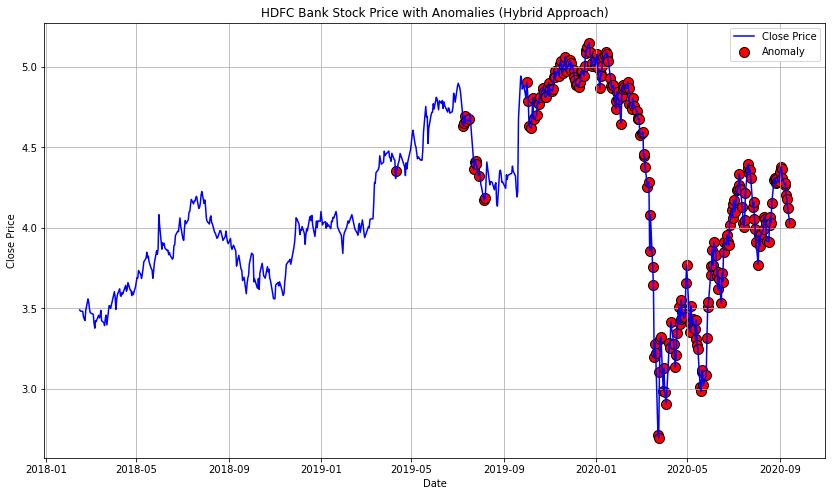

Number of anomalies detected by Hybrid Approach: 249
Detected Anomalies:
           Date         Open         High          Low        Close  \
5848 2019-02-25  1047.569946  1064.969971  1047.569946  1062.699951   
5906 2019-05-27  1189.449951  1210.949951  1186.119995  1204.180054   
5907 2019-05-28  1208.250000  1210.000000  1193.530029  1208.099976   
5908 2019-05-29  1205.099976  1215.400024  1205.099976  1208.449951   
5909 2019-05-30  1208.000000  1223.949951  1206.530029  1219.780029   
...         ...          ...          ...          ...          ...   
6194 2020-07-28  1079.000000  1094.400024  1059.500000  1086.650024   
6195 2020-07-29  1081.000000  1088.500000  1055.550049  1064.599976   
6196 2020-07-30  1074.000000  1083.650024  1046.699951  1050.650024   
6197 2020-07-31  1057.699951  1057.699951  1020.049988  1032.800049   
6198 2020-08-03  1025.949951  1026.949951   993.000000  1002.000000   

          Volume  
5848   4070298.0  
5906   6024512.0  
5907   3682420.0 

In [152]:
# Identify the common anomalies (intersection of all three methods)
common_anomalies = intersection_percentile_max.intersection(intersection_percentile_stat).intersection(intersection_max_stat)

# Convert to a sorted list for consistent ordering
common_anomalous_data_indices = sorted(list(common_anomalies))

# Plot anomalies using the hybrid approach
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[common_anomalous_data_indices], test_close.iloc[common_anomalous_data_indices], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Hybrid Approach)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of anomalies detected by the hybrid approach
print(f"Number of anomalies detected by Hybrid Approach: {len(common_anomalous_data_indices)}")

# Extract anomalies from the dataset
anomalies = test.iloc[common_anomalous_data_indices]

# Print the anomalies
print("Detected Anomalies:")
print(anomalies)

# Optionally, save anomalies to a CSV file
anomalies.to_csv('detected_anomalies_hybrid.csv', index=False)


Multivariate LSTM: Incorporates multiple features (Open, High, Low, Close, Volume), capturing complex relationships and dependencies between features, leading to potentially more accurate anomaly detection.
Threshold Methods: Similar methods are used for setting thresholds, but the Multivariate LSTM considers multiple features' reconstruction errors, providing a more comprehensive anomaly detection framework.

GRU MODEL

In [154]:
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(rate=0.2))
gru_model.add(RepeatVector(X_train.shape[1]))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(Dropout(rate=0.2))
gru_model.add(TimeDistributed(Dense(X_train.shape[2])))
gru_model.compile(optimizer='adam', loss='mae')
gru_model.summary()

# Train the GRU model
gru_history = gru_model.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.1,
                            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')],
                            shuffle=False)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 128)               51840     
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
gru_19 (GRU)                 (None, 30, 128)           99072     
_________________________________________________________________
dropout_37 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 5)             645       
Total params: 151,557
Trainable params: 151,557
Non-trainable params: 0
_______________________________________________

In [ ]:
# Plot training history
plt.plot(gru_history.history['loss'], label='GRU Training loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation loss')
plt.legend()
plt.show()

In [155]:
# Evaluate the GRU model
test_loss_gru = gru_model.evaluate(X_test, X_test, batch_size=16)
print(f'Test loss (GRU): {test_loss_gru}')

40/40 [==============================] - 0s 9ms/step - loss: 1.5406
Test loss (GRU): 1.5406394004821777


In [156]:
# Calculate reconstruction error for training data
X_train_pred_gru = gru_model.predict(X_train)
train_mae_loss_gru = np.mean(np.abs(X_train_pred_gru - X_train), axis=1)

Percentile Threshold (GRU): 0.5161018350918416


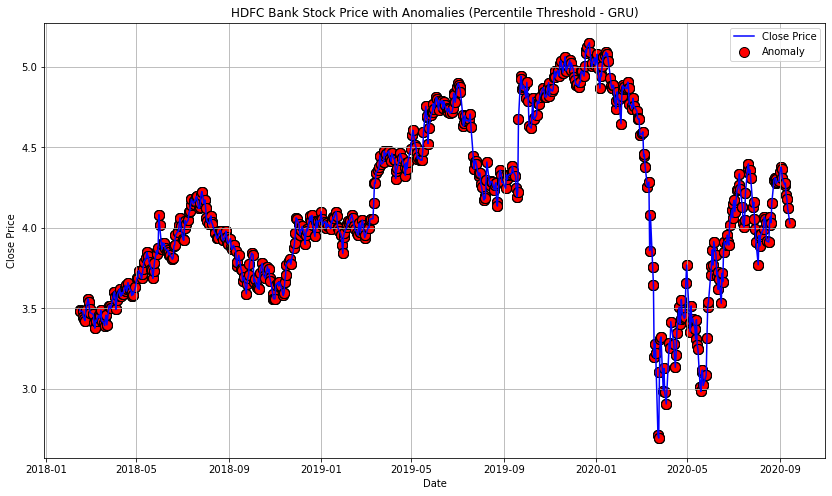

In [157]:
# Set threshold as the 95th percentile of the training MAE loss
percentile_threshold_gru = np.percentile(train_mae_loss_gru, 95)
print(f"Percentile Threshold (GRU): {percentile_threshold_gru}")

# Calculate reconstruction error for test data
X_test_pred_gru = gru_model.predict(X_test)
test_mae_loss_gru = np.mean(np.abs(X_test_pred_gru - X_test), axis=1)

# Detect anomalies
percentile_anomalies_gru = test_mae_loss_gru > percentile_threshold_gru
percentile_anomalous_data_indices_gru = np.where(percentile_anomalies_gru)[0]

# Plot anomalies using the percentile threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[percentile_anomalous_data_indices_gru], test_close.iloc[percentile_anomalous_data_indices_gru], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Percentile Threshold - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Max Threshold (GRU): 1.7468105042937587


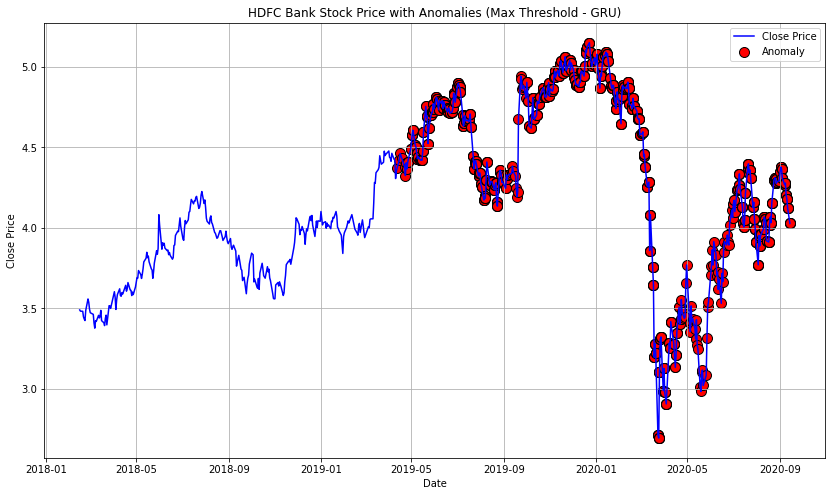

In [158]:
# Set threshold as the maximum of the training MAE loss
max_threshold_gru = np.max(train_mae_loss_gru)
print(f"Max Threshold (GRU): {max_threshold_gru}")

# Detect anomalies using the max threshold
max_anomalies_gru = test_mae_loss_gru > max_threshold_gru
max_anomalous_data_indices_gru = np.where(max_anomalies_gru)[0]

# Plot anomalies using the max threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[max_anomalous_data_indices_gru], test_close.iloc[max_anomalous_data_indices_gru], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Max Threshold - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Statistical Threshold (GRU): 0.7589640404017312


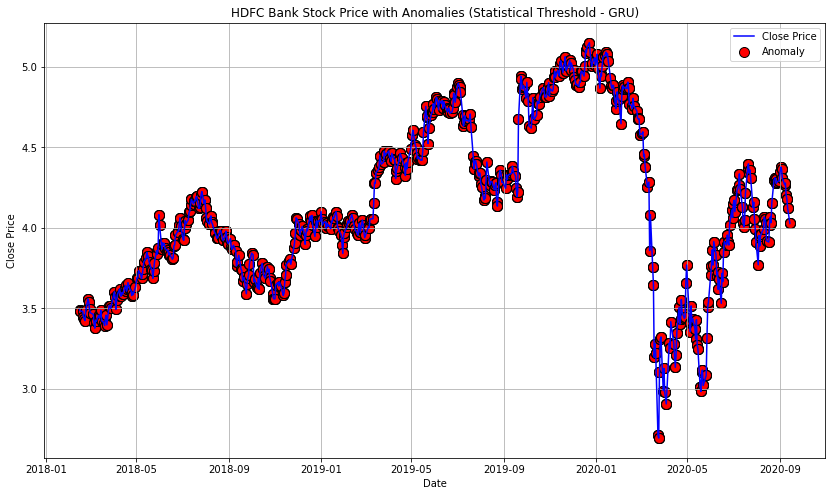

In [159]:
# Calculate mean and standard deviation of training MAE loss
mean_mae_gru = np.mean(train_mae_loss_gru)
std_mae_gru = np.std(train_mae_loss_gru)

# Set the threshold as mean + 3*std
stat_threshold_gru = mean_mae_gru + 3 * std_mae_gru
print(f"Statistical Threshold (GRU): {stat_threshold_gru}")

# Detect anomalies using the statistical threshold
stat_anomalies_gru = test_mae_loss_gru > stat_threshold_gru
stat_anomalous_data_indices_gru = np.where(stat_anomalies_gru)[0]

# Plot anomalies using the statistical threshold
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[stat_anomalous_data_indices_gru], test_close.iloc[stat_anomalous_data_indices_gru], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Statistical Threshold - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [160]:
# Count anomalies for each method
print(f"Number of anomalies detected (Percentile - GRU): {len(percentile_anomalous_data_indices_gru)}")
print(f"Number of anomalies detected (Max - GRU): {len(max_anomalous_data_indices_gru)}")
print(f"Number of anomalies detected (Statistical - GRU): {len(stat_anomalous_data_indices_gru)}")

# Summary of Anomalies Detected by Each Method (GRU)
percentile_anomalies_set_gru = set(percentile_anomalous_data_indices_gru)
max_anomalies_set_gru = set(max_anomalous_data_indices_gru)
stat_anomalies_set_gru = set(stat_anomalous_data_indices_gru)

# Compare overlaps
common_anomalies_percentile_max_gru = percentile_anomalies_set_gru.intersection(max_anomalies_set_gru)
common_anomalies_percentile_stat_gru = percentile_anomalies_set_gru.intersection(stat_anomalies_set_gru)
common_anomalies_max_stat_gru = max_anomalies_set_gru.intersection(stat_anomalies_set_gru)

Number of anomalies detected (Percentile - GRU): 3167
Number of anomalies detected (Max - GRU): 1151
Number of anomalies detected (Statistical - GRU): 3065


In [161]:
# Union of all anomalies
union_all_gru = percentile_anomalies_set_gru.union(max_anomalies_set_gru).union(stat_anomalies_set_gru)

print(f"Common anomalies (Percentile & Max - GRU): {len(common_anomalies_percentile_max_gru)}")
print(f"Common anomalies (Percentile & Statistical - GRU): {len(common_anomalies_percentile_stat_gru)}")
print(f"Common anomalies (Max & Statistical - GRU): {len(common_anomalies_max_stat_gru)}")
print(f"Unique anomalies (Total - GRU): {len(union_all_gru)}")


Common anomalies (Percentile & Max - GRU): 350
Common anomalies (Percentile & Statistical - GRU): 634
Common anomalies (Max & Statistical - GRU): 350
Unique anomalies (Total - GRU): 634


In [162]:
# Hybrid approach using GRU
common_anomalies_gru = common_anomalies_percentile_max_gru.intersection(common_anomalies_percentile_stat_gru).intersection(common_anomalies_max_stat_gru)
common_anomalous_data_indices_gru_hybrid = sorted(list(common_anomalies_gru))

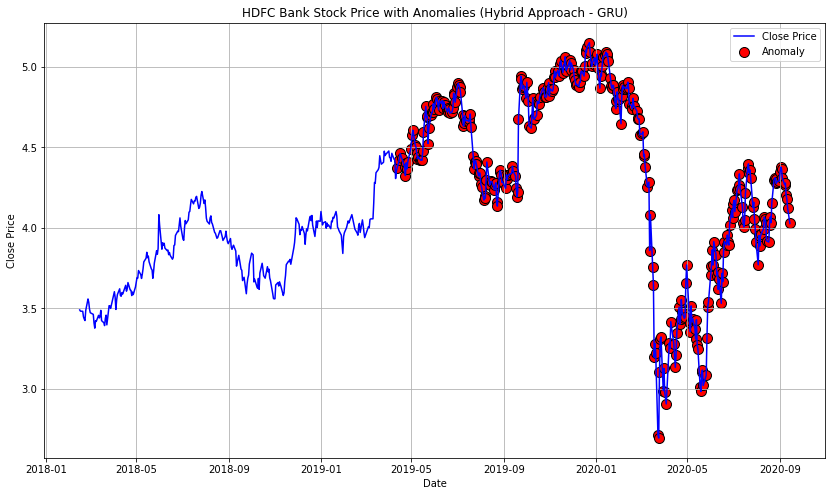

In [163]:
# Plot anomalies using the hybrid approach (GRU)
plt.figure(figsize=(14, 8))
plt.plot(test_dates, test_close, label='Close Price', color='blue')
plt.scatter(test_dates.iloc[common_anomalous_data_indices_gru_hybrid], test_close.iloc[common_anomalous_data_indices_gru_hybrid], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Hybrid Approach - GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [164]:
# Print the number of anomalies detected by the hybrid approach (GRU)
print(f"Number of anomalies detected by Hybrid Approach (GRU): {len(common_anomalous_data_indices_gru_hybrid)}")

Number of anomalies detected by Hybrid Approach (GRU): 350


Handle multiple features (e.g., open, high, low, close, volume), providing a more comprehensive analysis.
More complex models with higher computational requirements.
Multivariate models showed higher losses compared to univariate LSTM, indicating higher model complexity and potential overfitting.
Both LSTM and GRU models in the multivariate setting demonstrated similar patterns of overfitting.

In [165]:
# Extract anomalies from the dataset
anomalies_gru = test.iloc[common_anomalous_data_indices_gru_hybrid]

# Print the anomalies
print("Detected Anomalies (GRU):")
print(anomalies_gru)

# Optionally, save anomalies to a CSV file
anomalies_gru.to_csv('detected_anomalies_hybrid_gru.csv', index=False)

Detected Anomalies (GRU):
           Date         Open         High          Low        Close  \
5849 2019-02-26  1055.619995  1062.500000  1050.550049  1055.319946   
5850 2019-02-27  1058.050049  1062.219971  1044.069946  1046.119995   
5851 2019-02-28  1046.550049  1052.930054  1036.599976  1038.780029   
5852 2019-03-01  1043.119995  1050.449951  1038.500000  1041.680054   
5853 2019-03-05  1044.449951  1055.550049  1035.000000  1053.550049   
...         ...          ...          ...          ...          ...   
6194 2020-07-28  1079.000000  1094.400024  1059.500000  1086.650024   
6195 2020-07-29  1081.000000  1088.500000  1055.550049  1064.599976   
6196 2020-07-30  1074.000000  1083.650024  1046.699951  1050.650024   
6197 2020-07-31  1057.699951  1057.699951  1020.049988  1032.800049   
6198 2020-08-03  1025.949951  1026.949951   993.000000  1002.000000   

          Volume  
5849   4803714.0  
5850   3515046.0  
5851   5822688.0  
5852   4676464.0  
5853   5918638.0  
...    

ISOLATION FOREST

In [166]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(train[['Open', 'High', 'Low', 'Close', 'Volume']])

# Detect anomalies on the test set
test['anomaly'] = iso_forest.predict(test[['Open', 'High', 'Low', 'Close', 'Volume']])
test['anomaly'] = test['anomaly'].map({1: 0, -1: 1})  # 1 for normal, -1 for anomaly




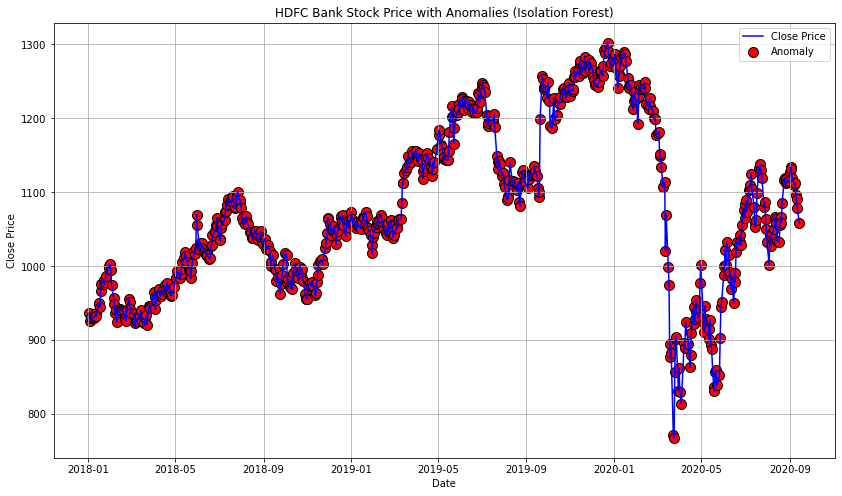

Detected Anomalies (Isolation Forest):
           Date         Open         High          Low        Close  \
5565 2018-01-02   929.275024   937.500000   929.275024   936.174988   
5566 2018-01-03   937.500000   939.125000   925.599976   926.325012   
5567 2018-01-04   926.500000   932.750000   926.500000   929.950012   
5568 2018-01-05   931.500000   934.025024   927.775024   931.799988   
5569 2018-01-08   932.500000   935.349976   928.875000   930.299988   
...         ...          ...          ...          ...          ...   
6224 2020-09-08  1114.000000  1118.800049  1103.000000  1112.449951   
6225 2020-09-09  1101.000000  1110.000000  1091.250000  1096.500000   
6226 2020-09-10  1103.000000  1104.849976  1084.000000  1090.550049   
6227 2020-09-11  1096.449951  1104.849976  1071.000000  1078.650024   
6228 2020-09-14  1088.000000  1094.000000  1052.349976  1057.949951   

          Volume  anomaly  
5565   2388158.0        1  
5566   2265644.0        1  
5567   1186888.0        

In [167]:
# Extract anomaly indices
iso_anomalous_data_indices = test[test['anomaly'] == 1].index

# Plot anomalies using the Isolation Forest method
plt.figure(figsize=(14, 8))
plt.plot(test['Date'], test['Close'], label='Close Price', color='blue')
plt.scatter(test.loc[iso_anomalous_data_indices]['Date'], test.loc[iso_anomalous_data_indices]['Close'], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the anomalies
anomalies_iso_forest = test.loc[iso_anomalous_data_indices]
print("Detected Anomalies (Isolation Forest):")
print(anomalies_iso_forest)



Number of anomalies detected by Isolation Forest: 662


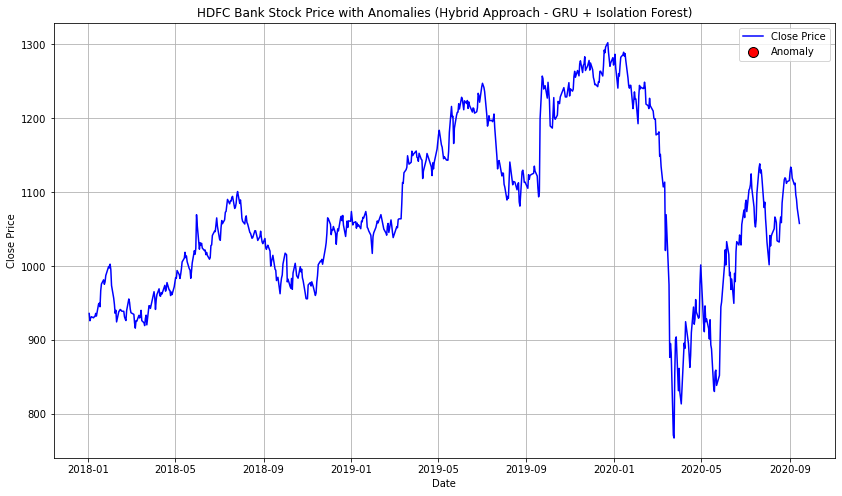

Number of anomalies detected by Hybrid Approach (GRU + Isolation Forest): 0
Detected Anomalies (Hybrid Approach - GRU + Isolation Forest):
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, anomaly]
Index: []


In [168]:
# Optionally, save anomalies to a CSV file
anomalies_iso_forest.to_csv('detected_anomalies_isolation_forest.csv', index=False)

# Calculate the number of anomalies detected
print(f"Number of anomalies detected by Isolation Forest: {len(iso_anomalous_data_indices)}")

# Combine the anomalies from GRU and Isolation Forest for a hybrid approach
common_anomalies_hybrid = set(common_anomalous_data_indices_gru_hybrid).intersection(set(iso_anomalous_data_indices))
common_anomalous_data_indices_hybrid = sorted(list(common_anomalies_hybrid))

# Plot anomalies using the hybrid approach (GRU + Isolation Forest)
plt.figure(figsize=(14, 8))
plt.plot(test['Date'], test['Close'], label='Close Price', color='blue')
plt.scatter(test.loc[common_anomalous_data_indices_hybrid]['Date'], test.loc[common_anomalous_data_indices_hybrid]['Close'], color='red', label='Anomaly', marker='o', s=100, edgecolors='k')
plt.title('HDFC Bank Stock Price with Anomalies (Hybrid Approach - GRU + Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of anomalies detected by the hybrid approach (GRU + Isolation Forest)
print(f"Number of anomalies detected by Hybrid Approach (GRU + Isolation Forest): {len(common_anomalous_data_indices_hybrid)}")

# Extract anomalies from the dataset
anomalies_hybrid = test.loc[common_anomalous_data_indices_hybrid]

# Print the anomalies
print("Detected Anomalies (Hybrid Approach - GRU + Isolation Forest):")
print(anomalies_hybrid)

# Optionally, save anomalies to a CSV file
anomalies_hybrid.to_csv('detected_anomalies_hybrid_gru_isolation_forest.csv', index=False)